In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # adapt plots for retina displays

from IPython.core.debugger import set_trace

In [2]:
import os
import utils
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import multiprocessing
import json

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

In [6]:
mask = utils.load_nifti('data/WM_GM_mask.nii.gz', z_factor=0.75)

/home/johannesr/anaconda2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [18]:
image_dir = '/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/'

# Data exploration

This is mainly to figure out what the values of the input data are and which normalization makes sense.

In [ ]:
data_dir = ''

In [50]:
all_struct_arr = np.zeros((10, 91, 109, 91))
for i, filename in enumerate(os.listdir(data_dir)[:10]):
    struct_arr = load_nifti(os.path.join(data_dir, filename), mask=mask)
    all_struct_arr[i] = struct_arr

In [55]:
def normalize(struct_arr):
    # Global normalization (i.e. subtract global mean and divide by global std).
    #return (struct_arr - all_struct_arr.mean()) / (all_struct_arr.std() + e)
    # Voxelwise normalization.
    return (struct_arr - all_struct_arr.mean(0)) / (all_struct_arr.std(0) + e)

In [56]:
which = 2

-0.0 1893.51379395 None None


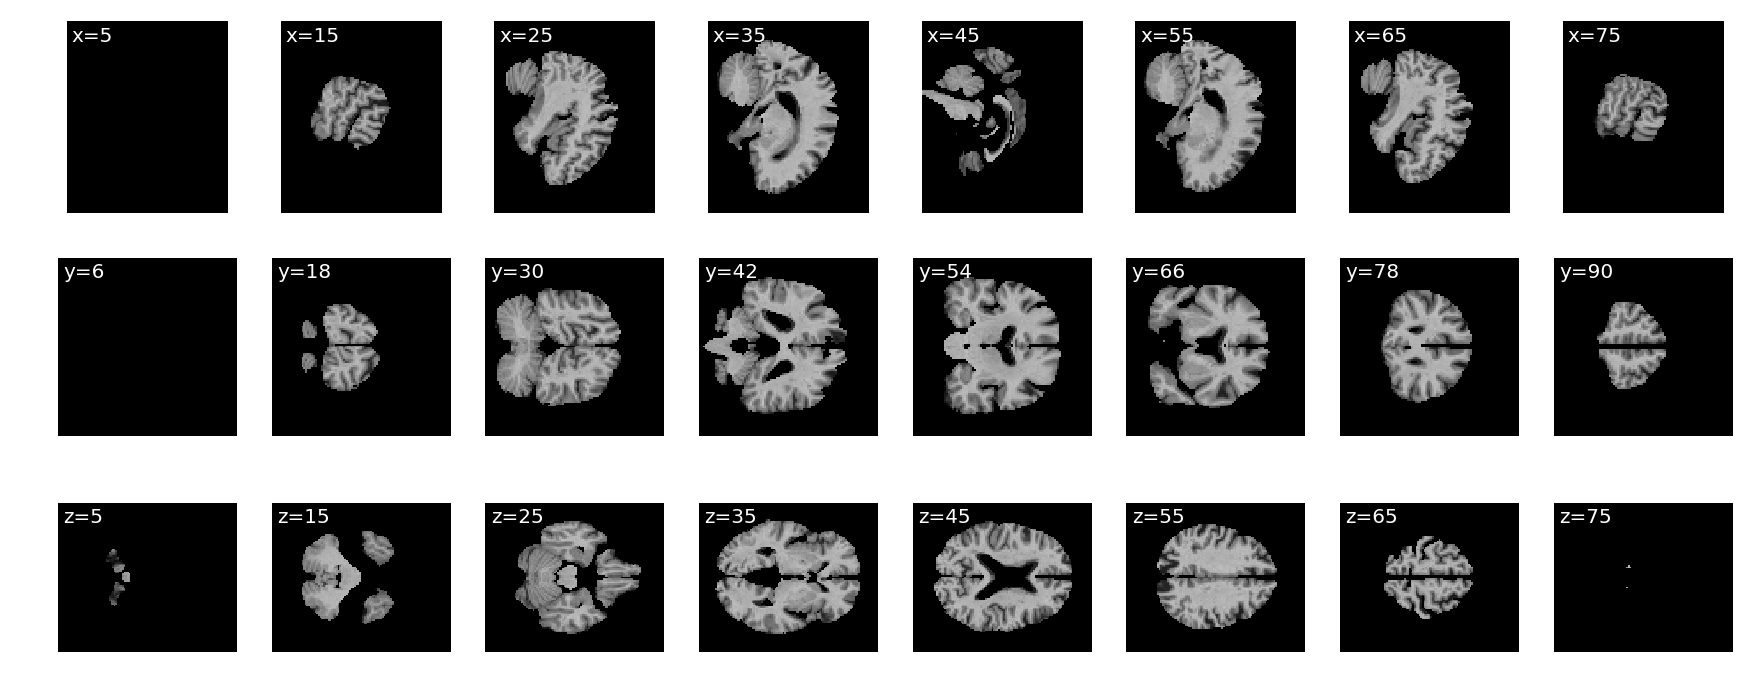

In [57]:
# Without normalization.
plot_slices(all_struct_arr[which])

-1.74211581794 2.9642684715 None None


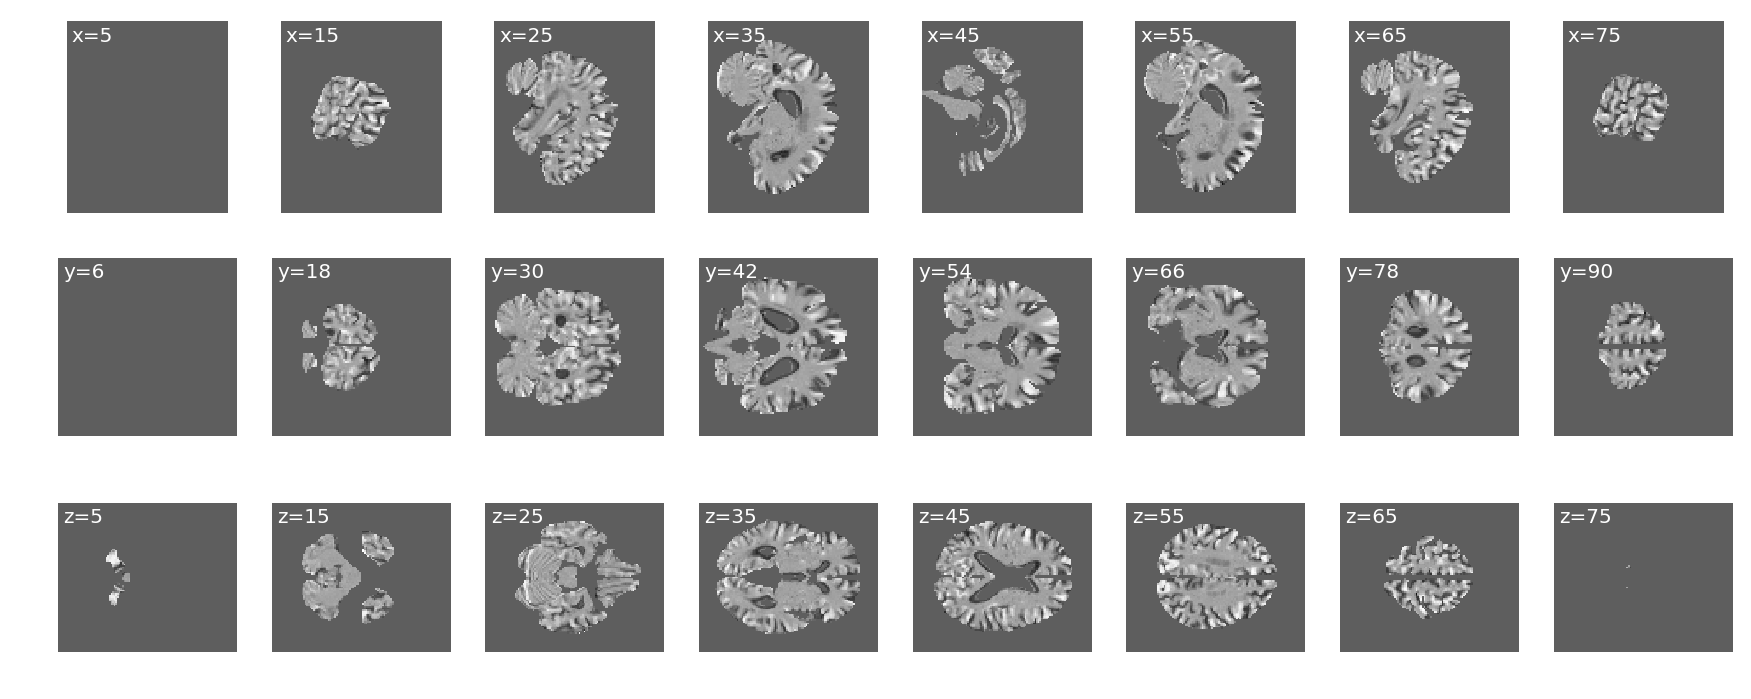

In [101]:
# With normalization.
plot_slices(normalize(all_struct_arr[6]))

0.0 531.285152101 None None


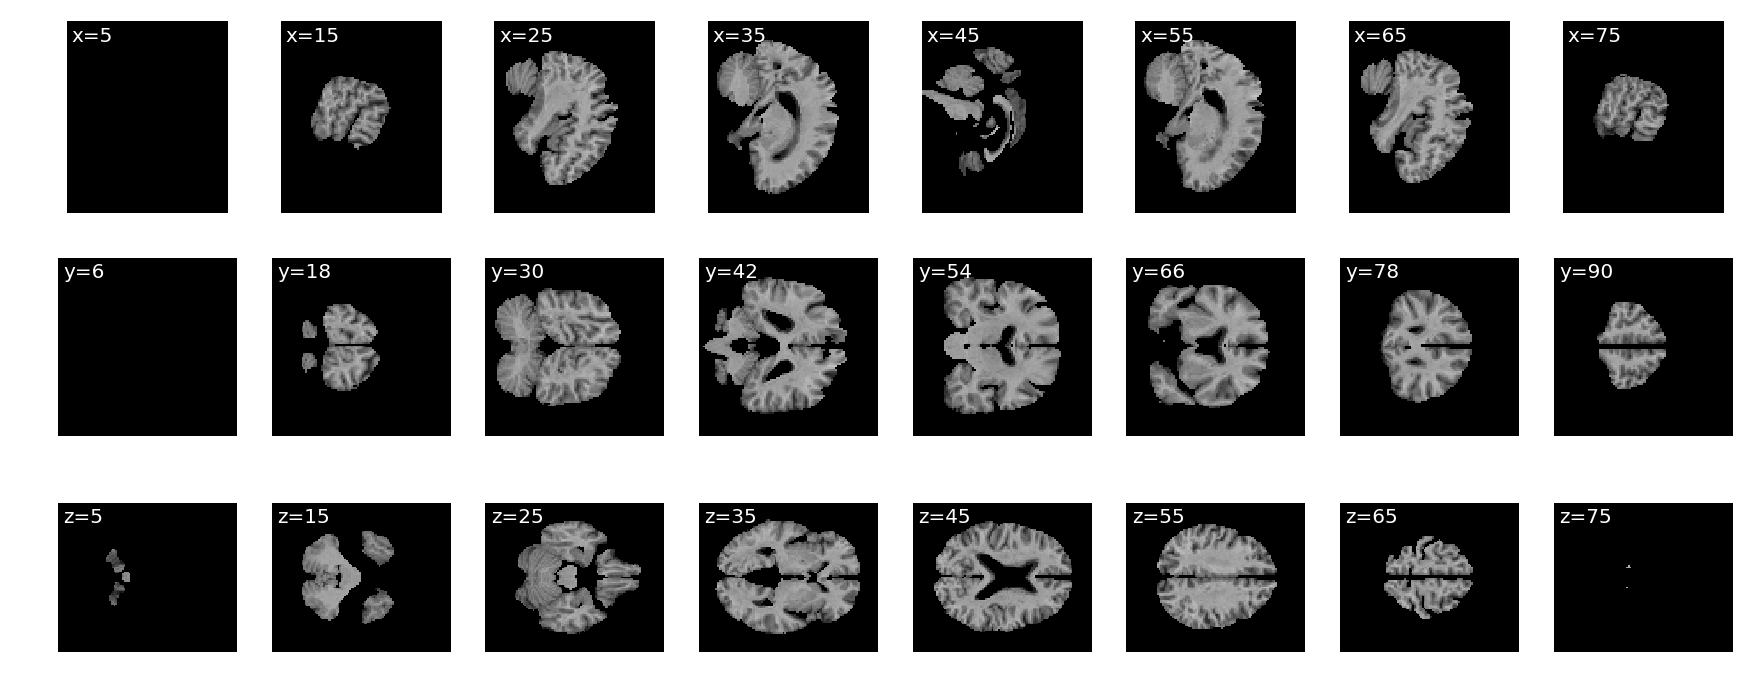

In [62]:
plot_slices(all_struct_arr.std(0))

In [82]:
all_struct_arr.std(0).shape, all_struct_arr.std(0).mean(), val_dataset.std.shape, val_dataset.std.mean()

((91, 109, 91), 55.312238839306545, (91, 109, 91), 35.68255602534866)

0.0 525.784363086 None None


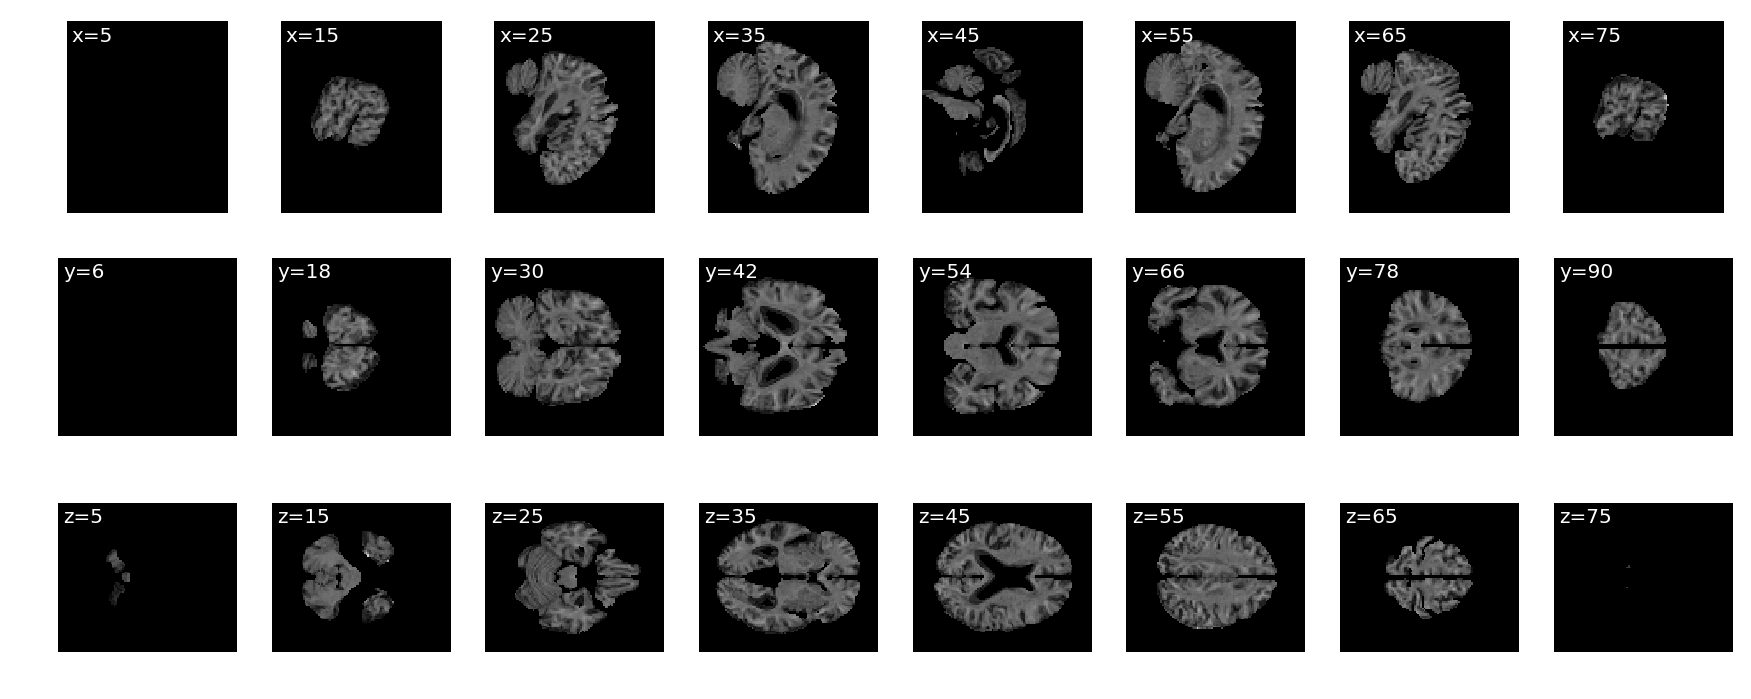

In [80]:
plot_slices(val_dataset.std)

-0.0 19.8802127838 None None


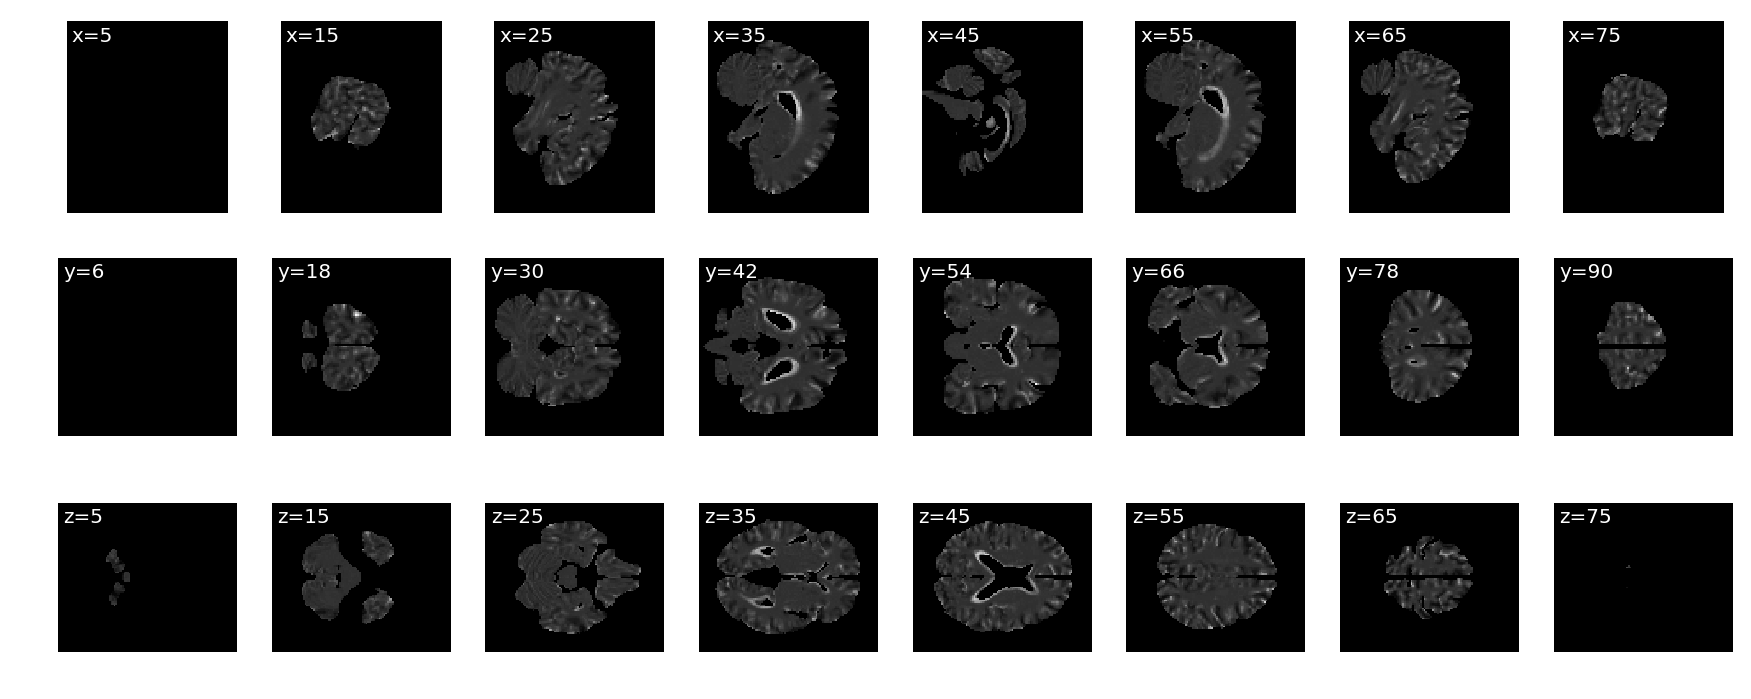

In [87]:
plot_slices(train_dataset[0][0][0])

-0.0 6.60129442755 None None


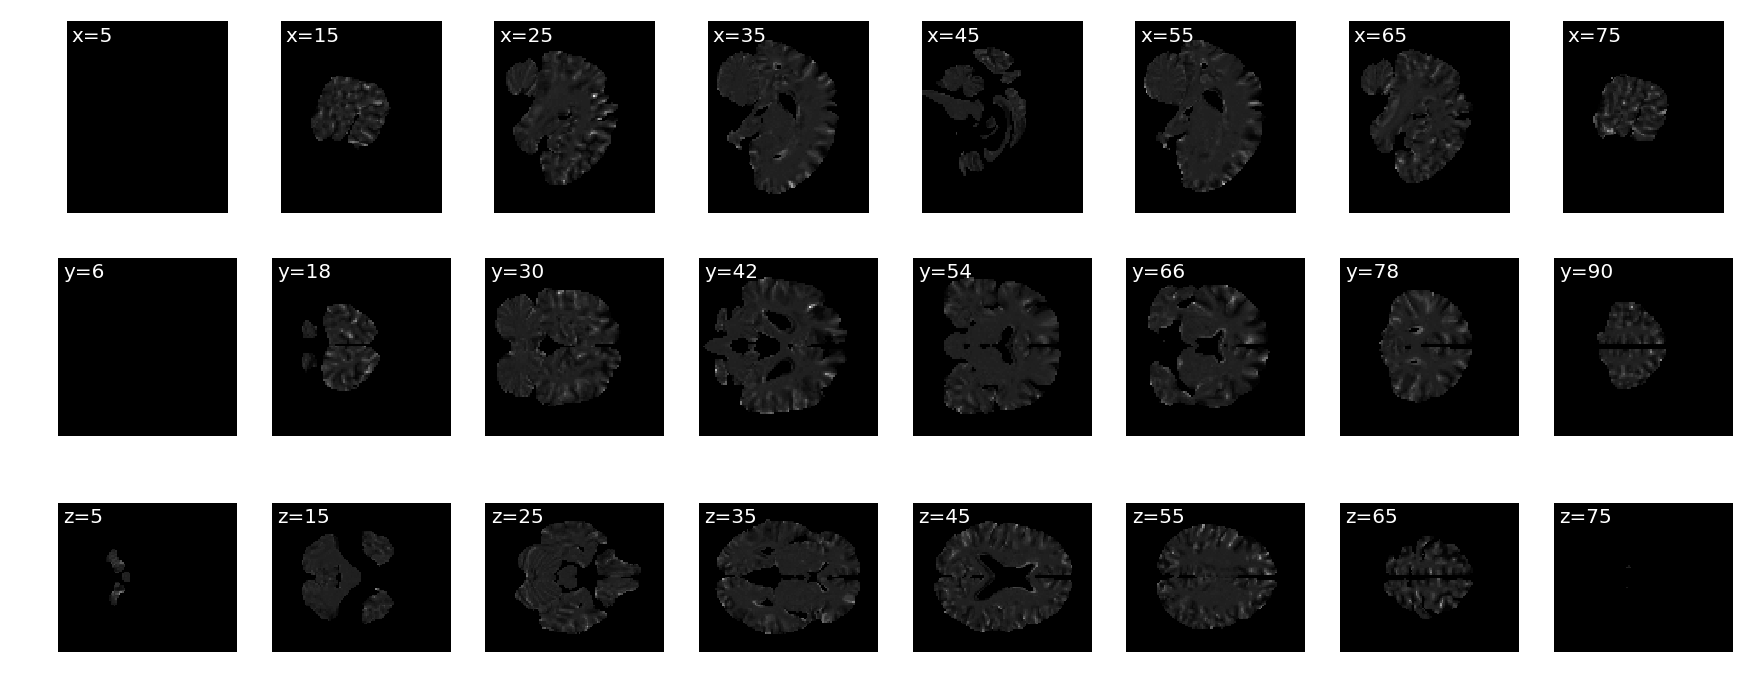

In [94]:
plot_slices((all_struct_arr[5]) / (all_struct_arr.std(0) + e))

In [104]:
from tabulate import tabulate

     min       max      mean      std
--------  --------  --------  -------
  0        878.652  138.734   147.395
  0       1080.93   139.514   164.709
  0       2475.49   458.859   498.345
  0       1032.4    167.046   167.691
  0        634.653  107.298   112.158
  0        746.643  111.941   123.482
-73.1235  2943.86   374.188   433.29
  0        611.206   99.4162  108.139
  0        766.627  105.494   116.77
  0        725.335  116.1     118.207


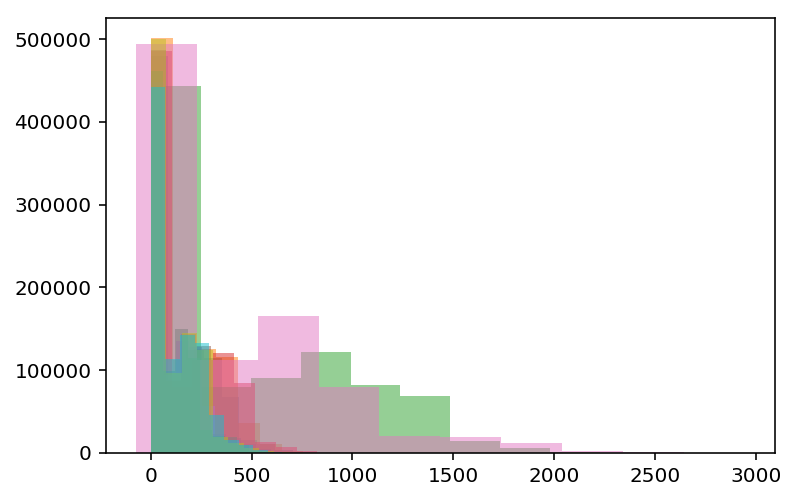

In [105]:
# Without mask.
table = []
for filename in os.listdir(data_dir)[:10]:
    struct_arr = load_nifti(os.path.join(data_dir, filename))
    table.append([struct_arr.min(), struct_arr.max(), struct_arr.mean(), struct_arr.std()])
    plt.hist(struct_arr.flatten(), alpha=0.5)
print(tabulate(table, headers=['min', 'max', 'mean', 'std']))

  min       max      mean       std
-----  --------  --------  --------
   -0   448.312   58.3633  119.693
   -0   916.809   69.1425  140.556
   -0  1893.51   210.079   426.996
   -0   642.567   71.6904  146.938
   -0   405.869   42.5109   85.8336
   -0   535.572   44.9789   91.5871
   -0  1208.63   135.899   282.577
   -0   440.731   34.3401   70.2301
   -0   435.472   45.4274   93.2796
   -0   383.535   46.64     94.91


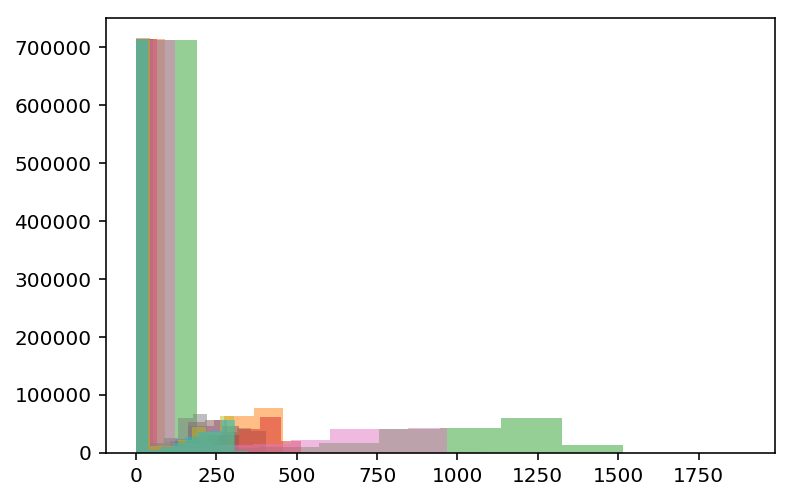

In [106]:
# With mask.
table = []
for filename in os.listdir(data_dir)[:10]:
    struct_arr = load_nifti(os.path.join(data_dir, filename), mask=mask)
    
    # Normalize.
    #struct_arr = (struct_arr - all_struct_arr.mean()) / (all_struct_arr.std() + e)
    
    table.append([struct_arr.min(), struct_arr.max(), struct_arr.mean(), struct_arr.std()])
    plt.hist(struct_arr.flatten(), alpha=0.5)
print(tabulate(table, headers=['min', 'max', 'mean', 'std']))

# Training on small dataset
This is a pytorch implementation of the experiment that Fabi ran in keras, see this notebook: https://github.com/derEitel/nn-experiments/blob/master/AD_NC_48_48.ipynb

## Load data

In [19]:
filenames = filter(lambda filename: filename.endswith('nii'), os.listdir(image_dir))
labels = map(lambda filename: 1 if filename.startswith('AD') else 0, filenames)
labels = np.array(labels)[:, None]
filenames = [os.path.join(image_dir, filename) for filename in filenames]
len(filenames), filenames[:5], labels[:5]

(98,
 [u'/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/AD_0076_wT1.nii',
  u'/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/NC_4264_wT1.nii',
  u'/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/NC_4026_wT1.nii',
  u'/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/AD_0213_wT1.nii',
  u'/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/NC_4090_wT1.nii'],
 array([[1],
        [0],
        [0],
        [1],
        [0]]))

In [20]:
from sklearn.model_selection import train_test_split
train_filenames, val_filenames, train_labels, val_labels = train_test_split(filenames, labels)

In [29]:
# New Dataset class to read all images.
# TODO: Maybe move this up and make it general across all experiments.

class ADNIDataset(Dataset):
    
    def __init__(self, filenames, labels, mask=None, remove_nan=True, transform=None):
            
        self.filenames = filenames
        self.labels = torch.Tensor(labels)
        self.mask = mask
        self.remove_nan = remove_nan
        self.transform = transform
        
        # Required by torchsample.
        self.num_inputs = 1
        self.num_targets = 1
        
        self.mean = 0
        self.std = 1
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
            
        struct_arr = utils.load_nifti(self.filenames[idx], mask=self.mask, remove_nan=self.remove_nan)
    
        # TODO: Maybe do this (at least the normalization) via transforms.
        # TODO: Maybe do normalization via mean as well.
        struct_arr = struct_arr / (self.std + e)
        struct_arr = struct_arr[None]  # add (empty) channel dimension
        struct_arr = torch.from_numpy(struct_arr).float()
        
        if self.transform is not None:
            struct_arr = self.transform(struct_arr)
        
        #label = torch.ones(1) if filename.startswith('AD') else torch.zeros(1)
        return struct_arr, label
    
    def image_shape(self):
        return utils.load_nifti(self.filenames[0], mask=mask).shape
    
    def get_std_and_mean(self, num_sample=None):
        if num_sample is None:
            num_sample = len(self)
        
        image_shape = self.image_shape()
        all_struct_arr = np.zeros((num_sample, image_shape[0], image_shape[1], image_shape[2]))
        
        for i, filename in enumerate(np.random.choice(self.filenames, num_sample, replace=False)):
            struct_arr = utils.load_nifti(filename, mask=mask, remove_nan=self.remove_nan)
            all_struct_arr[i] = struct_arr
            
        return all_struct_arr.std(0), all_struct_arr.mean(0)
    
    def get_raw_image(self, idx):
        return utils.load_nifti(self.filenames[idx], mask=self.mask, remove_nan=self.remove_nan)

In [30]:
train_dataset = ADNIDataset(train_filenames, train_labels, mask=mask)
val_dataset = ADNIDataset(val_filenames, val_labels, mask=mask)

In [32]:
# Only apply std normalization and no mean normalization, like in the original model.
std, mean = train_dataset.get_std_and_mean()
train_dataset.std = std
val_dataset.std = std

## Create model

In [33]:
# Original model from Fabi.
class ClassificationModel3D(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.Conv_1 = nn.Conv3d(1, 64, 3)
        self.Conv_2 = nn.Conv3d(64, 64, 3)
        self.Conv_3 = nn.Conv3d(64, 64, 3)
        self.Conv_4 = nn.Conv3d(64, 64, 3)
        self.dense_1 = nn.Linear(128, 1)
        self.elu = nn.ELU()
        
    def forward(self, inp):
        x = self.elu(self.Conv_1(inp))
        x = F.max_pool3d(x, 3)
        x = self.elu(self.Conv_2(x))
        x = F.max_pool3d(x, 3)
        x = self.elu(self.Conv_3(x))
        x = self.elu(self.Conv_4(x))
        x = F.max_pool3d(x, 3)
        x = x.view(x.size(0), -1)
        x = self.dense_1(x)
        
        # Note that no sigmoid is applied here, because the network is used in combination with BCEWithLogitsLoss,
        # which applies sigmoid and BCELoss at the same time to make it numerically stable.
        
        return x

In [34]:
net = ClassificationModel3D()
trainer = ModuleTrainer(net)

In [35]:
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.0001)
loss_function = nn.BCEWithLogitsLoss()

trainer.compile(loss=loss_function, optimizer=optimizer, metrics=[BinaryAccuracyWithLogits()], callbacks=[])

In [36]:
trainer.summary([1, 91, 109, 91])

OrderedDict([('Conv3d-1',
              OrderedDict([('input_shape', [-1, 1L, 91L, 109L, 91L]),
                           ('output_shape', [-1, 64L, 89L, 107L, 89L]),
                           ('trainable', True),
                           ('nb_params', 1792)])),
             ('ELU-2',
              OrderedDict([('input_shape', [-1, 64L, 89L, 107L, 89L]),
                           ('output_shape', [-1, 64L, 89L, 107L, 89L]),
                           ('nb_params', 0)])),
             ('Conv3d-3',
              OrderedDict([('input_shape', [-1, 64L, 29L, 35L, 29L]),
                           ('output_shape', [-1, 64L, 27L, 33L, 27L]),
                           ('trainable', True),
                           ('nb_params', 110656)])),
             ('ELU-4',
              OrderedDict([('input_shape', [-1, 64L, 27L, 33L, 27L]),
                           ('output_shape', [-1, 64L, 27L, 33L, 27L]),
                           ('nb_params', 0)])),
             ('Conv3d-5',
             

In [37]:
if torch.cuda.is_available():
    net = net.cuda()
    cuda_device = torch.cuda.current_device()
    print('Moved network to GPU')
else:
    cuda_device = -1
    print('GPU not available')

Moved network to GPU


## Train

In [38]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available()) 
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

In [39]:
trainer.fit_loader(train_loader,
            val_loader=val_loader,
            num_epoch=20, 
            verbose=1,
            cuda_device=cuda_device)

Epoch 1/20:   3%|▎         | 1/36 [00:02<01:27,  2.49s/ batches]


RuntimeError: CUDNN_STATUS_INTERNAL_ERROR

This usually achieves 80-90 % accuracy on validation data and 100 % accuracy on train data.

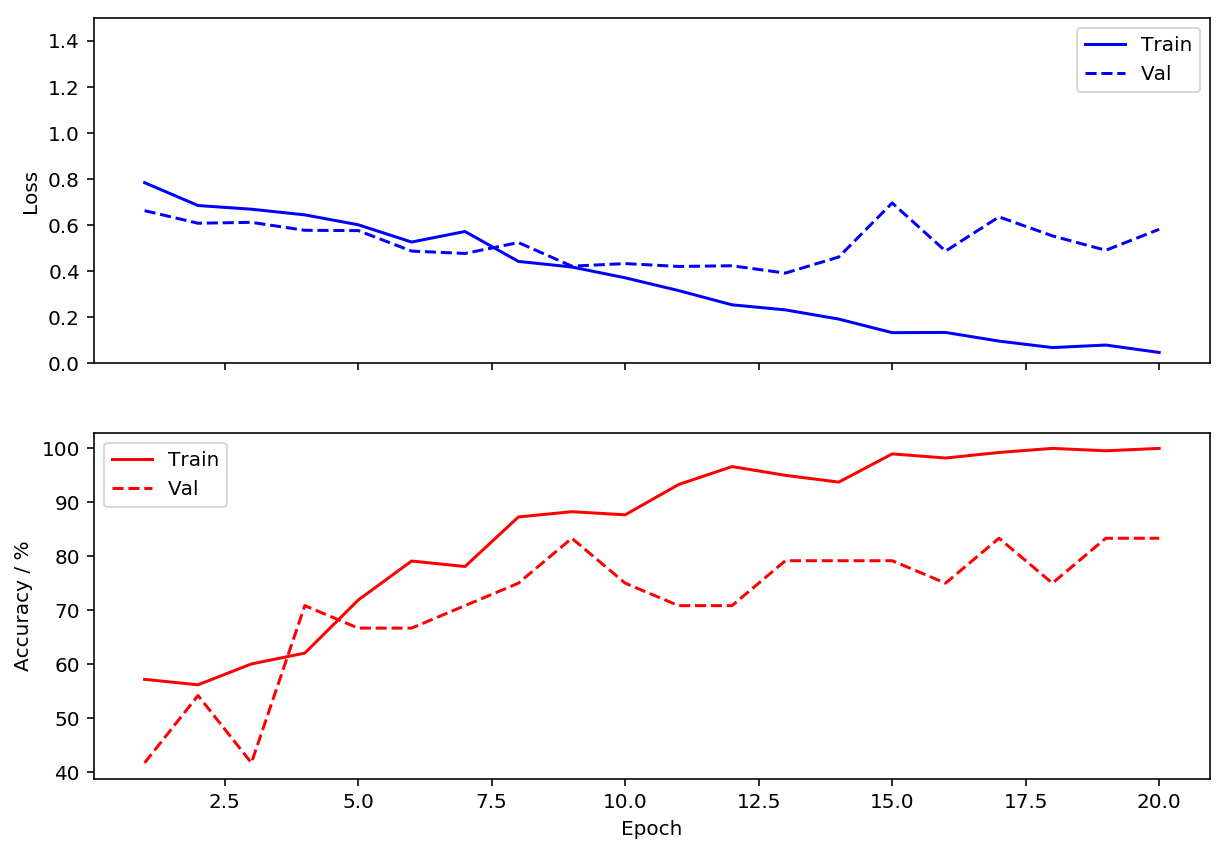

In [35]:
utils.plot_learning_curve(trainer.history)